## Objective

In this notebook we covered the implementation, training and performance analysis of a transfer learning model mainly using EfficientNet V2  in PyTorch in order to classify Coronary Artery Disease Cardiac. The EfficientNet model constructed in this notebook was able to achieve a accuracy of about ~0.99 on the test set, which is a significant indication that the model will generalise to unseen samples as a high accuracy  implies that model's predictions are statistically of high quality.

## Dataset

the dataset used in this notebook is the 'CAD Cardiac MRI Dataset'.Coronary Artery Disease Diagnosis based on Cardiac Magnetic Resonance Imaging This dataset contains 29843 images  which are classified into 2 classes: Normal and sick.
Link of dataset:https://www.kaggle.com/datasets/danialsharifrazi/cad-cardiac-mri-dataset/data

**Import libraries**

In [1]:
import random
import os
import glob
import time
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torch.optim.lr_scheduler as lr_scheduler

from torch import nn
from torch.utils.data import (Dataset, DataLoader)

from torchvision import transforms
from torchinfo import summary

from PIL import Image
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple
from scikitplot.metrics import plot_roc

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, top_k_accuracy_score, f1_score, 
    matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
)

## Splitting data

In this dataset, we have two main folders: "normal" and "sick". Inside each of these two folders, there are subfolders containing images. To facilitate the process of splitting and labeling the images into train, test, and validation sets, we use the following code.
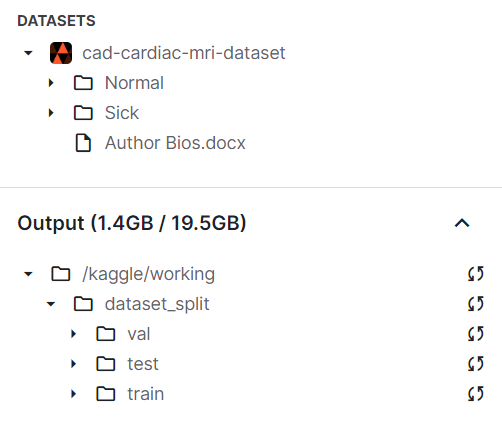

In [2]:
import os
import shutil
import random

# Define input and output directories
input_dir = '/kaggle/input/cad-cardiac-mri-dataset'
output_dir = '/kaggle/working/dataset_split'

# Create output directories for train, val, and test
os.makedirs(os.path.join(output_dir, 'train', 'normal'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'train', 'sick'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val', 'normal'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val', 'sick'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test', 'normal'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test', 'sick'), exist_ok=True)

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Function to split data
def split_data(class_dir, class_name):
    files = []
    for root, _, filenames in os.walk(class_dir):
        for filename in filenames:
            files.append(os.path.join(root, filename))
    random.shuffle(files)
    num_files = len(files)
    
    train_end = int(train_ratio * num_files)
    val_end = int((train_ratio + val_ratio) * num_files)
    
    # Copy files to train directory
    for file in files[:train_end]:
        shutil.copy(file, os.path.join(output_dir, 'train', class_name))
    
    # Copy files to validation directory
    for file in files[train_end:val_end]:
        shutil.copy(file, os.path.join(output_dir, 'val', class_name))
    
    # Copy files to test directory
    for file in files[val_end:]:
        shutil.copy(file, os.path.join(output_dir, 'test', class_name))

# Split data for "normal" class
normal_dir = os.path.join(input_dir, 'Normal')
split_data(normal_dir, 'normal')

# Split data for "sick" class
sick_dir = os.path.join(input_dir, 'Sick')
split_data(sick_dir, 'sick')

print("Dataset split completed successfully.")


Dataset split completed successfully.


## Configuration Class (CFG)

- NUM_CLASSES = 2:
- EPOCHS = 30
- BATCH_SIZE=64
- LR = 0.0001
- SEED = 768

In [166]:
import os
import torch
import pandas as pd
import glob
import warnings

# Define the configuration
class CFG:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_DEVICES = torch.cuda.device_count()
    NUM_WORKERS = os.cpu_count()
    NUM_CLASSES = 2
    EPOCHS = 30
    BATCH_SIZE = (
        64 if torch.cuda.device_count() < 2 
        else (64 * torch.cuda.device_count())
    )
    LR = 0.0001
    APPLY_SHUFFLE = True
    SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)
    
    # Define paths
    DATASET_PATH = "/kaggle/working/dataset_split"
    TRAIN_PATH = '/kaggle/working/dataset_split/train'
    TEST_PATH = '/kaggle/working/dataset_split/test'
    VAL_PATH = '/kaggle/working/dataset_split/val'

# Mute warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

**Get image paths with glob**

In [167]:
%%time
train_images = glob.glob(f"{CFG.TRAIN_PATH}**/*.jpg")
test_images = glob.glob(f"{CFG.TEST_PATH}**/*.jpg")
val_images = glob.glob(f"{CFG.VAL_PATH}**/*.jpg")

CPU times: user 1.89 ms, sys: 880 µs, total: 2.77 ms
Wall time: 1.94 ms


**Create Pandas DataFrames for paths and labels**

In the code below, I create a DataFrame containing two columns: one for the path of each image and another for the label of each image.

In [168]:
def generate_labels(image_paths):
    return [(_.split('/')[-2:][0]).replace('-', '_') for _ in image_paths]

def build_df(image_paths, labels):
    # Create dataframe
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })
    return df

# Define paths for train, test, and validation datasets
train_images = glob.glob(f"{CFG.TRAIN_PATH}/**/*.jpg", recursive=True)
test_images = glob.glob(f"{CFG.TEST_PATH}/**/*.jpg", recursive=True)
val_images = glob.glob(f"{CFG.VAL_PATH}/**/*.jpg", recursive=True)

# Build DataFrames for train, test, and validation datasets
train_df = build_df(train_images, generate_labels(train_images))
test_df = build_df(test_images, generate_labels(test_images))
val_df = build_df(val_images, generate_labels(val_images))

# View first 5 samples in the validation dataset
train_df.head(5)

image_path label
0  /kaggle/working/dataset_split/train/sick/IM000...  sick
1  /kaggle/working/dataset_split/train/sick/IM000...  sick
2  /kaggle/working/dataset_split/train/sick/IM110...  sick
3  /kaggle/working/dataset_split/train/sick/IM030...  sick
4  /kaggle/working/dataset_split/train/sick/IM140...  sick

**Load & View Random Sample Image**

In [169]:
def _load(image_path, as_tensor=True):
    # Read and decode an image file to a uint8 tensor
    image = Image.open(image_path)
    
    if as_tensor:
        converter = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Grayscale()
        ])
        return converter(image)
    else:
        return image


def view_sample(image, label, color_map='rgb', fig_size=(8, 10)):
    plt.figure(figsize=fig_size)
    
    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=color_map)
    
    plt.title(f'Label: {label}', fontsize=16)
    return

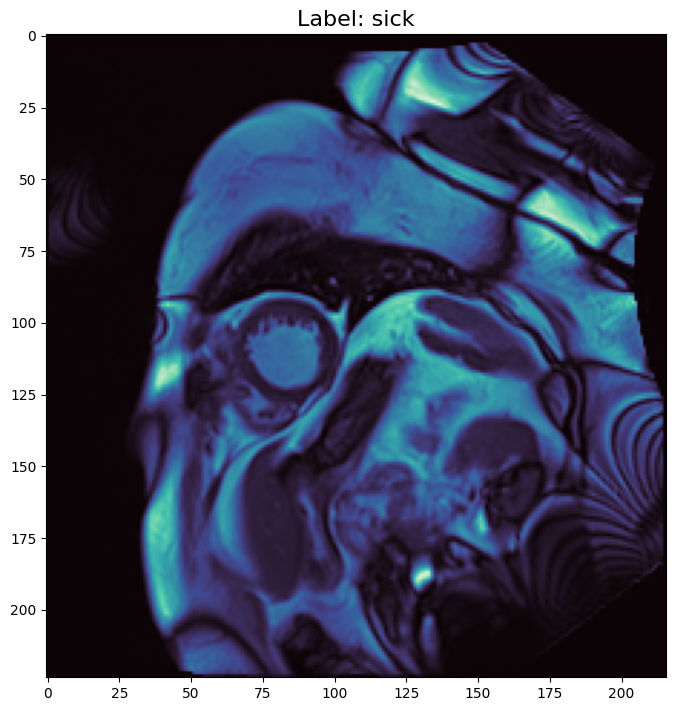

In [171]:
# Select random sample from train_df
idx = random.sample(train_df.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_label = _load(train_df.image_path[idx]), train_df.label[idx]

# View the random sample
view_sample(
    sample_image.permute(1, 2, 0),
    sample_label,
    color_map='mako',
)

**View Multiple Randomly Selected Samples**

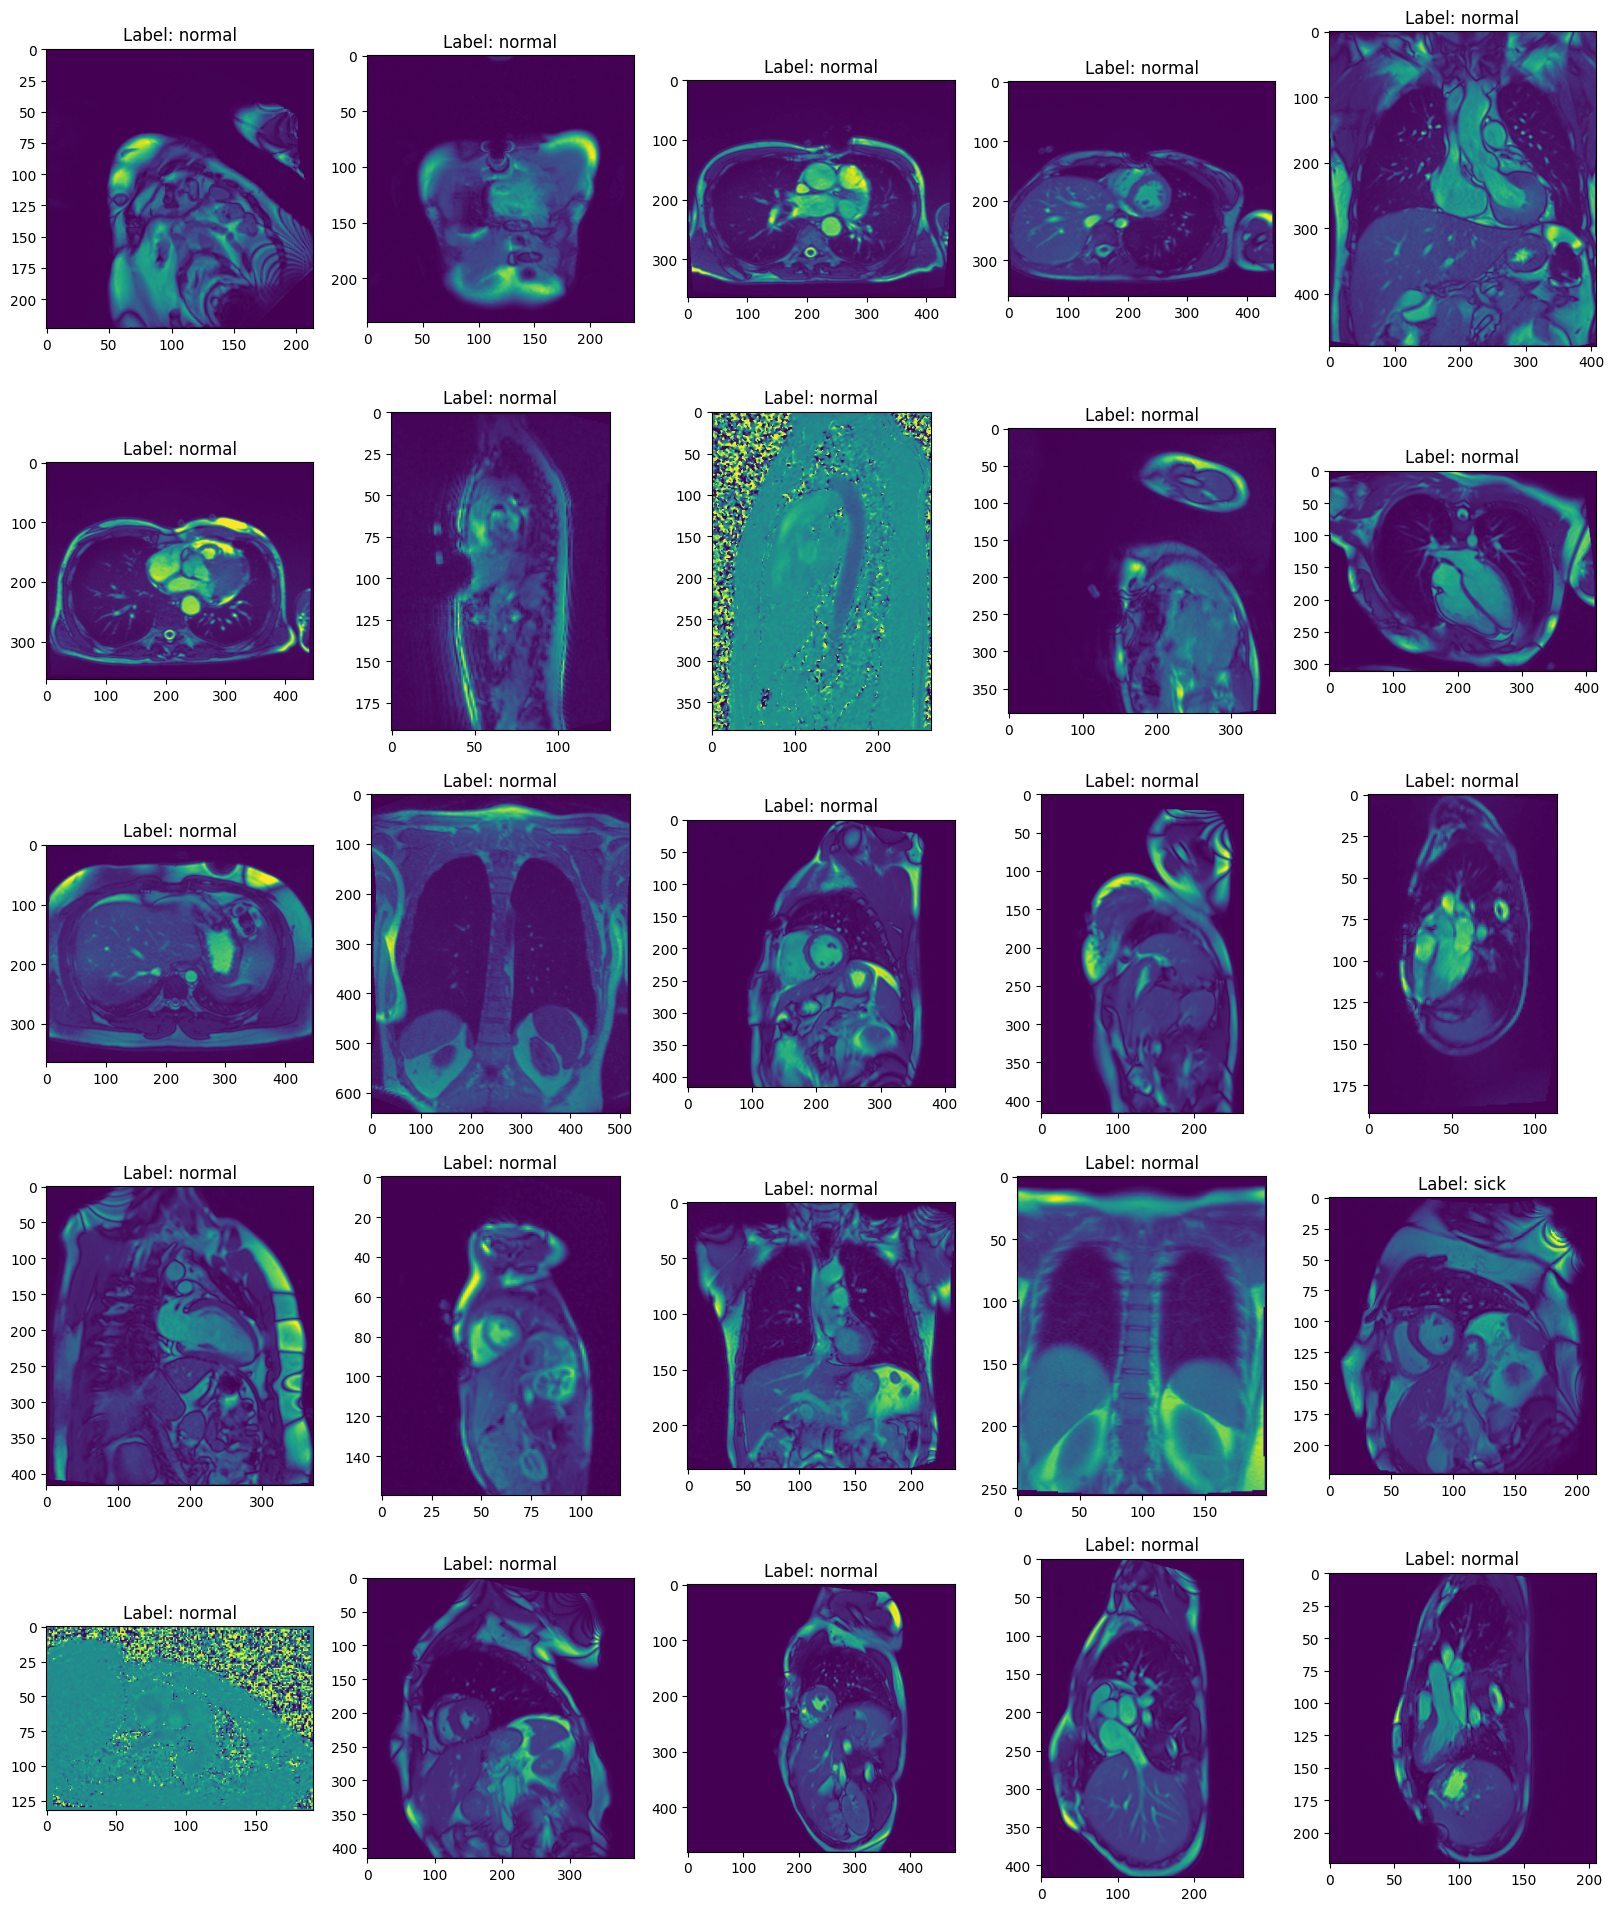

In [172]:
def view_mulitiple_samples(df, sample_loader, count=10, color_map='rgb', fig_size=(14, 10)):
    rows = count//5
    if count%5 > 0:
        rows +=1
    
    idx = random.sample(df.index.to_list(), count)    
    fig = plt.figure(figsize=fig_size)

    for column, _ in enumerate(idx):
        plt.subplot(rows, 5, column+1)
        plt.title(f'Label: {df.label[_]}')
        
        if color_map=='rgb':
            plt.imshow(sample_loader(df.image_path[_]).permute(1, 2, 0))
        else:
            plt.imshow(sample_loader(df.image_path[_]).permute(1, 2, 0), cmap=color_map)
    
    return

# View 25 random sample images
view_mulitiple_samples(
    train_df, _load, 
    count=25, 
    fig_size=(20, 24)
)

In [120]:
train_df.shape, val_df.shape,test_df.shape

((19167, 2), (5335, 2), (5341, 2))

**Summary of splitting  data**

In [121]:
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)
total = train_size + val_size + test_size

# View the counts
print(f'train samples count:\t\t{train_size}\t({(100 * train_size/total):.2f}%)')
print(f'validation samples count:\t{val_size}\t({(100 * val_size/total):.2f}%)')
print(f'test samples count:\t\t{test_size}\t({(100 * test_size/total):.2f}%)')
print('================================================')
print(f'TOTAL:\t\t\t\t{total}\t({(100 * total/total):.2f}%)')

train samples count:		19167	(64.23%)
validation samples count:	5335	(17.88%)
test samples count:		5341	(17.90%)
TOTAL:				29843	(100.00%)


## Build Custom Datasets & DataLoaders

In [122]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

# Only reshape test data
test_transforms = transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

In [123]:
class CardiacMRIDataset(Dataset):
    def __init__(self, df:pd.DataFrame, transform=None) -> None:
        super().__init__()
        
        self.paths = df['image_path'].to_list()
        self.labels = df['label'].to_list()
        self.transform = transform
        
        self.classes = sorted(list(df['label'].unique()))
        self.class_to_idx = {cls_name: _ for _, cls_name in enumerate(self.classes)}
        
    def load_image(self, index:int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path).convert('RGB')  
        
    def __len__(self) -> int:
        return self.paths.__len__()
    
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        image = self.load_image(index)
        class_name = self.labels[index]
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(image), class_idx
        else:
            return image, class_idx

**Build Custom Datasets**

In [124]:
# Build train dataset
train_ds = CardiacMRIDataset(train_df, transform=train_transforms)

# Build validation dataset
val_ds = CardiacMRIDataset(val_df, transform=test_transforms)

# Build test dataset
test_ds = CardiacMRIDataset(test_df, transform=test_transforms)

**Build DataLoaders from Custom Datasets**

In [125]:
# Build train dataloader
train_loader = DataLoader(
    dataset=train_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=CFG.APPLY_SHUFFLE
)

# Build validation dataloader
val_loader = DataLoader(
    dataset=val_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)

# Build test dataloader
test_loader = DataLoader(
    dataset=test_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)

##  Transfer Learning Model: EfficientNet V2 Large


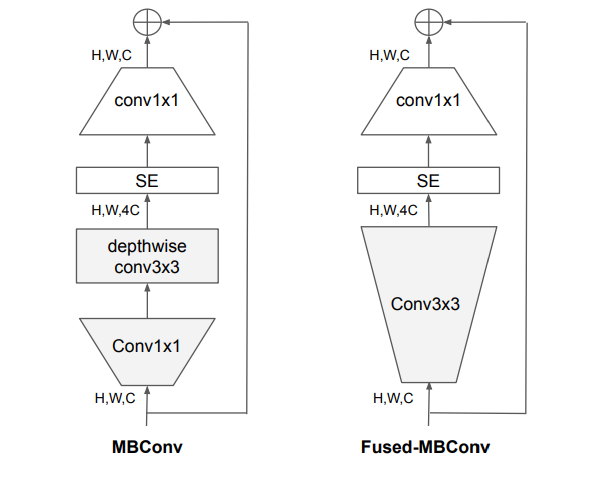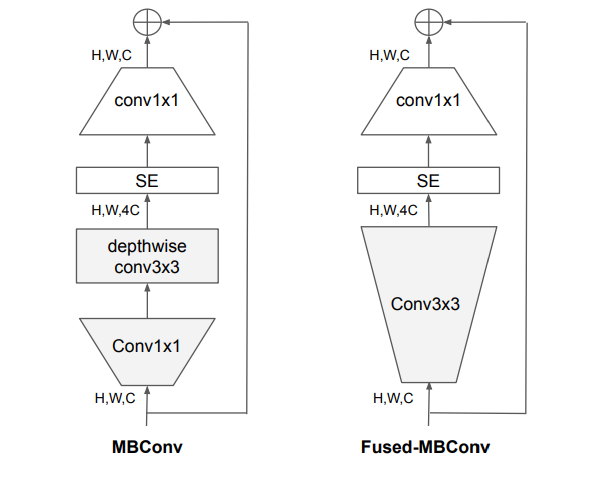

EfficientNet V2 is a convolutional neural network that has faster training speed and better parameter efficiency than previous EfficientNet V1 models. To develop these models, the authors use a combination of training-aware neural architecture search and scaling, to jointly optimize training speed. The models were searched from the search space enriched with new ops such as Fused-MBConv.

In [126]:
class EfficientNetV2Model(nn.Module):
    def __init__(self, backbone_model, name='efficientnet-v2-large', 
                 num_classes=CFG.NUM_CLASSES, device=CFG.DEVICE):
        super(EfficientNetV2Model, self).__init__()
        
        self.backbone_model = backbone_model
        self.device = device
        self.num_classes = num_classes
        self.name = name
        
        classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2, inplace=True), 
            nn.Linear(in_features=1280, out_features=256, bias=True),
            nn.GELU(),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=256, out_features=num_classes, bias=False)
        ).to(device)
        
        self._set_classifier(classifier)
        
    def _set_classifier(self, classifier:nn.Module) -> None:
        self.backbone_model.classifier = classifier
    
    def forward(self, image):
        return self.backbone_model(image)

In [127]:
def get_effiecientnetv2_model(
    device: torch.device=CFG.NUM_CLASSES) -> nn.Module:
    # Set the manual seeds
    torch.manual_seed(CFG.SEED)
    torch.cuda.manual_seed(CFG.SEED)

    # Get model weights
    model_weights = (
        torchvision
        .models
        .EfficientNet_V2_L_Weights
        .DEFAULT
    )
    
    # Get model and push to device
    model = (
        torchvision.models.efficientnet_v2_l(
            weights=model_weights
        )
    ).to(device) 
    
    # Freeze Model Parameters
    for param in model.features.parameters():
        param.requires_grad = False
        
    return model

In [128]:
# Get EfficientNet v2 model
backbone_model = get_effiecientnetv2_model(CFG.DEVICE)

In [129]:
efficientnetv2_params = {
    'backbone_model'    : backbone_model,
    'name'              : 'efficientnet-v2-large',
    'device'            : CFG.DEVICE
}

# Generate Model
efficientnet_model = EfficientNetV2Model(**efficientnetv2_params)

# If using GPU T4 x2 setup, use this:
if CFG.NUM_DEVICES > 1:
    efficientnet_model = nn.DataParallel(efficientnet_model)

In [130]:
# View model summary
summary(
    model=efficientnet_model, 
    input_size=(CFG.BATCH_SIZE, CFG.CHANNELS, CFG.WIDTH, CFG.HEIGHT),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
EfficientNetV2Model (EfficientNetV2Model)                         [64, 3, 224, 224]    [64, 2]              --                   Partial
├─EfficientNet (backbone_model)                                   [64, 3, 224, 224]    [64, 2]              --                   Partial
│    └─Sequential (features)                                      [64, 3, 224, 224]    [64, 1280, 7, 7]     --                   False
│    │    └─Conv2dNormActivation (0)                              [64, 3, 224, 224]    [64, 32, 112, 112]   (928)                False
│    │    └─Sequential (1)                                        [64, 32, 112, 112]   [64, 32, 112, 112]   (37,120)             False
│    │    └─Sequential (2)                                        [64, 32, 112, 112]   [64, 64, 56, 56]     (1,032,320)          False
│    │    └─Sequential (3)                     

## Train Model

**Define Loss & Optimizer**

In [131]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss(
    label_smoothing=0.1
)

# Define Optimizer
optimizer = torch.optim.AdamW(
    efficientnet_model.parameters(),
    lr=CFG.LR
)

**Define Epoch Execution (Train Step)**

In [132]:
def execute_epoch(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    # Set model into training mode
    model.train()
    
    # Initialize train loss & accuracy
    train_loss, train_acc = 0, 0
    
    # Execute training loop over train dataloader
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Load data onto target device
        X, y = X.to(device), y.to(device)
        
        # Feed-forward and compute metrics
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        
        # Reset Gradients & Backpropagate Loss
        optimizer.zero_grad()
        loss.backward()
        
        # Update Model Gradients
        optimizer.step()
        
        # Compute Batch Metrics
        predicted_class = torch.argmax(
            torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (predicted_class == y).sum().item() / len(y_pred)
        
    # Compute Step Metrics
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc

**Define Evaluation Step**

In [133]:
def evaluate(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    # Set model into eval mode
    model.eval()
    
    # Initialize eval loss & accuracy
    eval_loss, eval_acc = 0, 0
    
    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(dataloader):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            eval_loss += loss.item() 

            # Compute Batch Metrics
            predicted_class = torch.argmax(
                torch.softmax(y_pred, dim=1), dim=1)
            eval_acc += (predicted_class == y).sum().item() / len(y_pred)
        
    # Compute Step Metrics
    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)
    
    return eval_loss, eval_acc

**Construct Training Loop**

In [134]:
def train(
    model:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    eval_dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    epochs:int,
    device:torch.device) -> Dict[str, List]:
    
    # Initialize training session
    session = {
        'loss'          : [],
        'accuracy'      : [],
        'eval_loss'     : [],
        'eval_accuaracy': []
    }
    
    # Training loop
    for epoch in tqdm(range(epochs)):
        # Execute Epoch
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_loss, train_acc = execute_epoch(
            model, 
            train_dataloader, 
            optimizer, 
            loss_fn, 
            device
        )
        
        # Evaluate Model
        eval_loss, eval_acc = evaluate(
            model, 
            eval_dataloader,
            loss_fn, 
            device
        )
        
        # Log Epoch Metrics
        print(f'loss: {train_loss:.4f} - acc: {train_acc:.4f} - eval_loss: {eval_loss:.4f} - eval_acc: {eval_acc:.4f}')
        
        # Record Epoch Metrics
        session['loss'].append(train_loss)
        session['accuracy'].append(train_acc)
        session['eval_loss'].append(eval_loss)
        session['eval_accuaracy'].append(eval_acc)
        
    # Return Session Metrics
    return session

**Train EfficientNet Model**

In [135]:
# Train the model 
print('Training EfficientNet Model')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

efficientnet_session_config = {
    'model'               : efficientnet_model,
    'train_dataloader'    : train_loader,
    'eval_dataloader'     : val_loader,
    'optimizer'           : optimizer,
    'loss_fn'             : loss_fn,
    'epochs'              : CFG.EPOCHS,
    'device'              : CFG.DEVICE
}

efficientnet_session_history = train(**efficientnet_session_config)

Training EfficientNet Model
Train on 19167 samples, validate on 5335 samples.
----------------------------------


  0%|          | 0/30 [00:00<?, ?it/s]


Epoch 1/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2930 - acc: 0.9544 - eval_loss: 0.2764 - eval_acc: 0.9794

Epoch 2/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2492 - acc: 0.9816 - eval_loss: 0.2525 - eval_acc: 0.9818

Epoch 3/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2355 - acc: 0.9882 - eval_loss: 0.2451 - eval_acc: 0.9833

Epoch 4/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2273 - acc: 0.9907 - eval_loss: 0.2398 - eval_acc: 0.9834

Epoch 5/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2221 - acc: 0.9921 - eval_loss: 0.2391 - eval_acc: 0.9836

Epoch 6/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2194 - acc: 0.9930 - eval_loss: 0.2370 - eval_acc: 0.9836

Epoch 7/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2181 - acc: 0.9931 - eval_loss: 0.2394 - eval_acc: 0.9840

Epoch 8/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2165 - acc: 0.9933 - eval_loss: 0.2367 - eval_acc: 0.9846

Epoch 9/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2160 - acc: 0.9935 - eval_loss: 0.2354 - eval_acc: 0.9851

Epoch 10/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2146 - acc: 0.9941 - eval_loss: 0.2340 - eval_acc: 0.9857

Epoch 11/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2128 - acc: 0.9947 - eval_loss: 0.2324 - eval_acc: 0.9855

Epoch 12/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2126 - acc: 0.9949 - eval_loss: 0.2326 - eval_acc: 0.9864

Epoch 13/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2129 - acc: 0.9948 - eval_loss: 0.2322 - eval_acc: 0.9866

Epoch 14/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2123 - acc: 0.9948 - eval_loss: 0.2313 - eval_acc: 0.9872

Epoch 15/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2112 - acc: 0.9954 - eval_loss: 0.2302 - eval_acc: 0.9877

Epoch 16/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2104 - acc: 0.9957 - eval_loss: 0.2299 - eval_acc: 0.9879

Epoch 17/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2107 - acc: 0.9955 - eval_loss: 0.2292 - eval_acc: 0.9883

Epoch 18/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2099 - acc: 0.9958 - eval_loss: 0.2315 - eval_acc: 0.9881

Epoch 19/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2098 - acc: 0.9960 - eval_loss: 0.2292 - eval_acc: 0.9896

Epoch 20/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2089 - acc: 0.9964 - eval_loss: 0.2283 - eval_acc: 0.9894

Epoch 21/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2093 - acc: 0.9964 - eval_loss: 0.2277 - eval_acc: 0.9888

Epoch 22/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2090 - acc: 0.9962 - eval_loss: 0.2274 - eval_acc: 0.9896

Epoch 23/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2085 - acc: 0.9964 - eval_loss: 0.2280 - eval_acc: 0.9900

Epoch 24/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2081 - acc: 0.9965 - eval_loss: 0.2282 - eval_acc: 0.9892

Epoch 25/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2083 - acc: 0.9966 - eval_loss: 0.2279 - eval_acc: 0.9898

Epoch 26/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2079 - acc: 0.9965 - eval_loss: 0.2274 - eval_acc: 0.9898

Epoch 27/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2075 - acc: 0.9969 - eval_loss: 0.2271 - eval_acc: 0.9901

Epoch 28/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2074 - acc: 0.9969 - eval_loss: 0.2271 - eval_acc: 0.9905

Epoch 29/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2070 - acc: 0.9974 - eval_loss: 0.2274 - eval_acc: 0.9898

Epoch 30/30


  0%|          | 0/300 [00:00<?, ?it/s]

loss: 0.2071 - acc: 0.9972 - eval_loss: 0.2262 - eval_acc: 0.9900


In [136]:
def predict(
    model:nn.Module, 
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:
    
    # Set model into eval mode
    model.eval()
    
    predictions = []
    
    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(tqdm(sample_loader)):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X) 

            # Compute Batch Metrics
            predicted_probs = torch.softmax(y_pred, dim=1).cpu().numpy()
            
            # Record prediction
            predictions.append(predicted_probs)
        
    return np.vstack(predictions)

In [137]:
# Generate test sample probabilities 
efficientnet_test_probs = predict(efficientnet_model, test_loader, CFG.DEVICE)

  0%|          | 0/84 [00:00<?, ?it/s]

In [138]:
# Generate test sample preditions 
efficientnet_test_preds = np.argmax(efficientnet_test_probs, axis=1)

## Performance Analysis

In [139]:
def plot_training_curves(history):
    
    loss = np.array(history['loss'])
    val_loss = np.array(history['eval_loss'])

    accuracy = np.array(history['accuracy'])
    val_accuracy = np.array(history['eval_accuaracy'])

    epochs = range(len(history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='eval_loss', marker='o')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='eval_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();
    
    sns.despine();
    
    return

In [140]:
# Convert EfficientNet history dict to DataFrame
efficientnet_session_history_df = pd.DataFrame(efficientnet_session_history)
efficientnet_session_history_df

loss  accuracy  eval_loss  eval_accuaracy
0   0.293035  0.954427   0.276375        0.979353
1   0.249234  0.981615   0.252472        0.981771
2   0.235467  0.988229   0.245096        0.983259
3   0.227326  0.990677   0.239811        0.983445
4   0.222062  0.992135   0.239083        0.983631
5   0.219424  0.993021   0.237035        0.983631
6   0.218137  0.993125   0.239389        0.984003
7   0.216544  0.993333   0.236731        0.984561
8   0.215969  0.993490   0.235367        0.985119
9   0.214604  0.994062   0.233977        0.985677
10  0.212804  0.994687   0.232399        0.985491
11  0.212633  0.994896   0.232577        0.986421
12  0.212858  0.994788   0.232247        0.986607
13  0.212306  0.994844   0.231289        0.987165
14  0.211198  0.995365   0.230170        0.987723
15  0.210442  0.995729   0.229875        0.987909
16  0.210671  0.995521   0.229237        0.988281
17  0.209925  0.995833   0.231531        0.988095
18  0.209806  0.995990   0.229215        0.989583
19  0.208909  0.996351   0.228307        0.989397
20  0.209347  0.996354   0.227658        0.988839
21  0.209037  0.996198   0.227383        0.989583
22  0.208547  0.996354   0.228035        0.989955
23  0.208130  0.996458   0.228224        0.989211
24  0.208323  0.996615   0.227929        0.989769
25  0.207893  0.996510   0.227375        0.989769
26  0.207453  0.996875   0.227095        0.990141
27  0.207440  0.996875   0.227130        0.990513
28  0.207036  0.997448   0.227446        0.989769
29  0.207106  0.997188   0.226195        0.989955

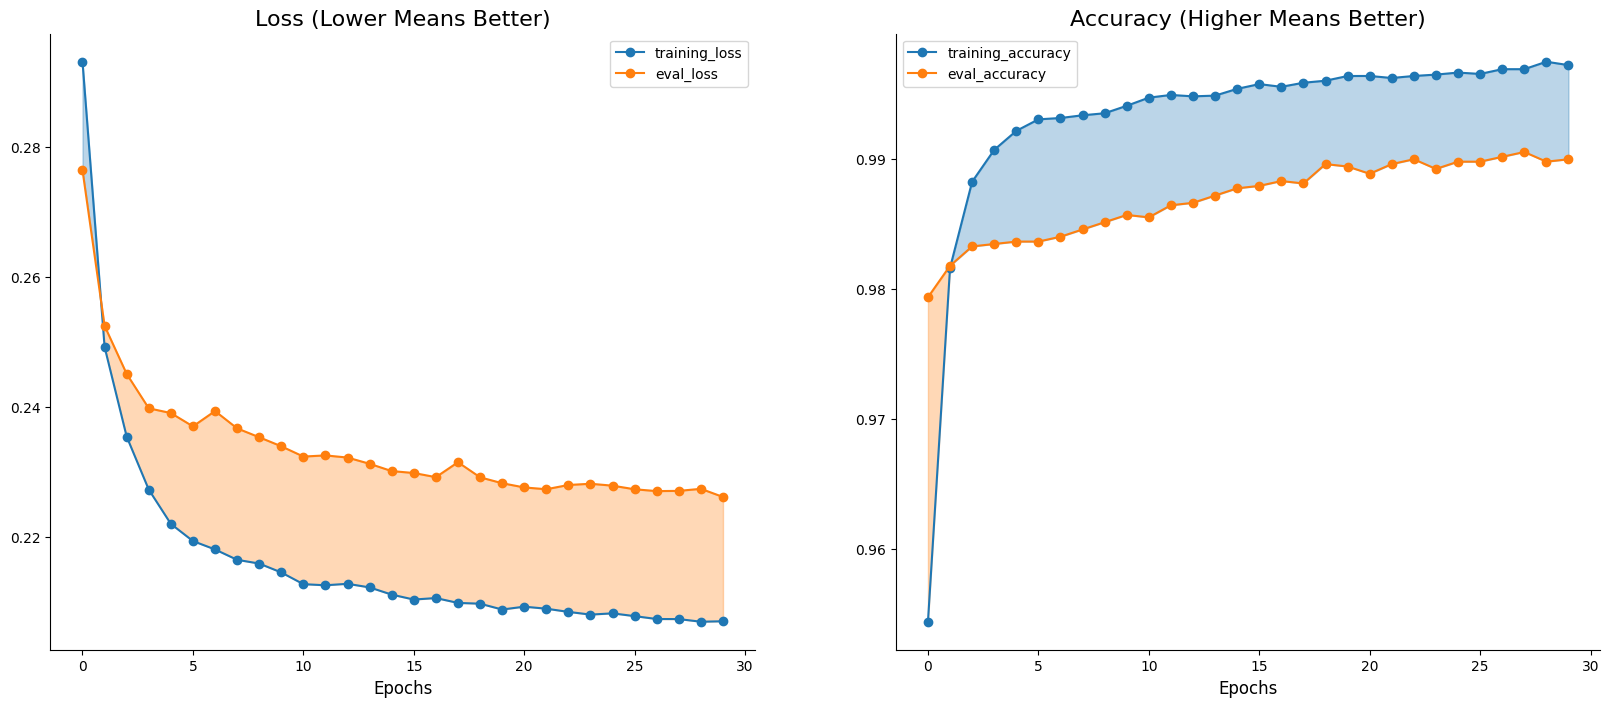

In [141]:
# Plot EfficientNet session training history 
plot_training_curves(efficientnet_session_history)

The loss curve demonstrates the behavior of the model's loss function over training epochs.
- Training loss decreases steadily over epochs, indicating that the model is learning to minimize errors on the training data.
- Evaluation (or validation) loss also decreases, showing that the model generalizes well to unseen data, as it learns to make accurate predictions on the validation set.

The accuracy curve depicts the model's classification accuracy over training epochs.
- Training accuracy increases as the model learns from the training data, correctly classifying more examples.
- Evaluation accuracy similarly rises, demonstrating the model's ability to generalize its learned patterns to new, unseen data, resulting in improved overall performance.


In [142]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12): 
    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.5, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0) 

    # Plot confusion matrix
    plt.show()
    
    return


In [143]:
test_labels = [*map(test_ds.class_to_idx.get, test_ds.labels)]

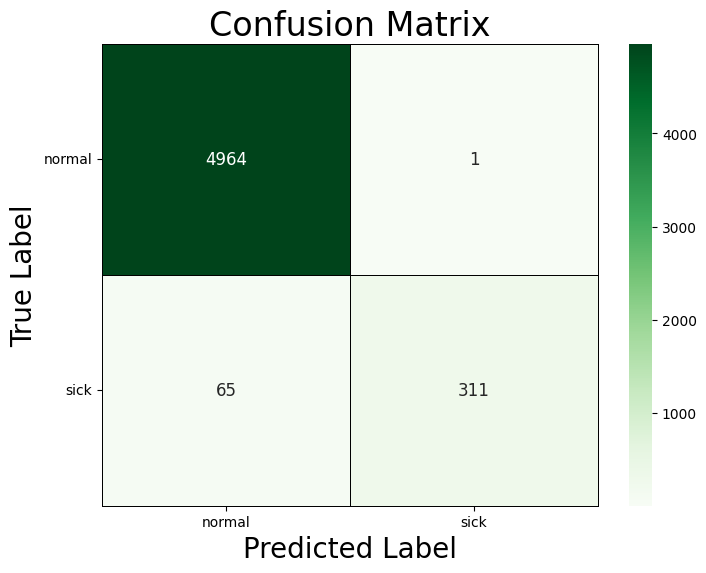

In [177]:
plot_confusion_matrix(
    test_labels, 
    efficientnet_test_preds, 
    figsize=(8, 6),  
    classes=test_ds.classes)

The confusion matrix provides a detailed breakdown of the classification performance of a model, including counts of instances for each class.
- There are 4964 instances classified as positive that are correctly predicted as positive (true positives).
- 65 instances are positive but classified as negative (false negatives).
- 311 instances classified as negative that are correctly predicted as negative (true negatives).
- Only 1 instance is negative but classified as positive (false positive).



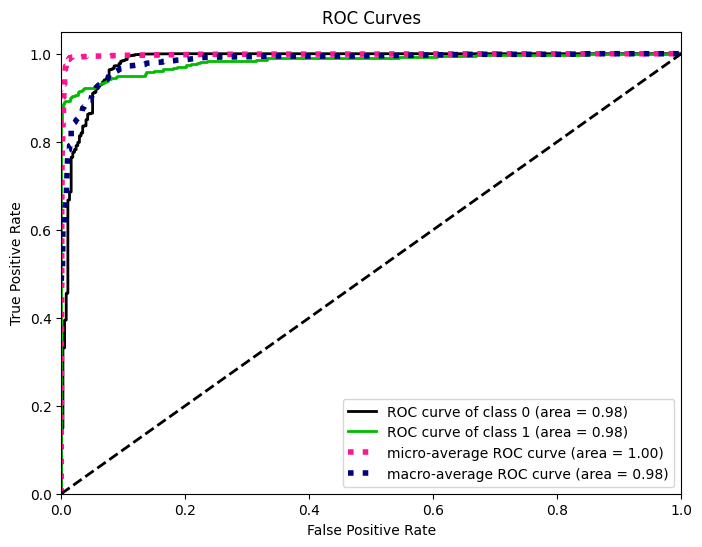

In [176]:
plot_roc(
    test_labels, 
    efficientnet_test_probs, 
    figsize=(8, 6), title_fontsize='large'
);


In [146]:
print(
    classification_report(
        test_labels, 
        efficientnet_test_preds, 
        target_names=test_ds.classes
))

              precision    recall  f1-score   support

      normal       0.99      1.00      0.99      4965
        sick       1.00      0.83      0.90       376

    accuracy                           0.99      5341
   macro avg       0.99      0.91      0.95      5341
weighted avg       0.99      0.99      0.99      5341



In [147]:
efficientnet_results = pd.DataFrame({
    'image_path'       : test_ds.paths,
    'label'            : test_ds.labels,
    'label_encoded'    : test_labels,
    'model_prediction' : efficientnet_test_preds,
    'model_probability': [
        efficientnet_test_probs[_][pred] for _, pred in zip(
            range(len(efficientnet_test_probs)), 
            efficientnet_test_preds
        )]
})

efficientnet_results

image_path   label  \
0     /kaggle/working/dataset_split/test/sick/IM0001...    sick   
1     /kaggle/working/dataset_split/test/sick/IM0004...    sick   
2     /kaggle/working/dataset_split/test/sick/IM1100...    sick   
3     /kaggle/working/dataset_split/test/sick/IM0701...    sick   
4     /kaggle/working/dataset_split/test/sick/IM0011...    sick   
...                                                 ...     ...   
5336  /kaggle/working/dataset_split/test/normal/img0...  normal   
5337  /kaggle/working/dataset_split/test/normal/img0...  normal   
5338  /kaggle/working/dataset_split/test/normal/img0...  normal   
5339  /kaggle/working/dataset_split/test/normal/img0...  normal   
5340  /kaggle/working/dataset_split/test/normal/img0...  normal   

      label_encoded  model_prediction  model_probability  
0                 1                 0           0.936945  
1                 1                 0           0.676342  
2                 1                 1           0.997198  
3                 1                 1           0.966002  
4                 1                 1           0.994819  
...             ...               ...                ...  
5336              0                 0           0.957644  
5337              0                 0           0.956517  
5338              0                 0           0.959111  
5339              0                 0           0.960580  
5340              0                 0           0.944555  

[5341 rows x 5 columns]

In [148]:
def view_multiple_predictions(df, classes, sample_loader, count=10, color_map='rgb', title=None, fig_size=(14, 10)):
    rows = count//5
    if count%5 > 0:
        rows +=1
    
    idx = random.sample(df.index.to_list(), count)
    
    fig = plt.figure(figsize=fig_size)
    if title != None:
        fig.suptitle(title, fontsize=30)
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    
    # Setup useful dictionaries
    label_set = {k: v for k, v in enumerate(classes)}
    color_set = {False: 'red', True: 'darkgreen'}
    
    for column, _ in enumerate(idx):
        # Predict label
        img = sample_loader(df.image_path[_]).permute(1, 2, 0)
        
        # Validate prediction correctness
        correct_prediction = (df.model_prediction[_] == df.label_encoded[_])
        
        # Create subplot and assign title
        ax = plt.subplot(rows, 5, column+1)
        ax.set_title(
            f'Actual Label: {df.label[_]}', 
            pad=20, 
            fontsize=14,
            color=color_set[correct_prediction]
        )
        
        # Plot image
        if color_map=='rgb':
            ax.imshow(img)
        else:
            ax.imshow(img, cmap=color_map)
        
        # Plot prediction  & probability
        txt = f'Prediction: {label_set[df.model_prediction[_]]}\nProbability: {(100 * df.model_probability[_]):.2f}%'
        plt.xlabel(txt, fontsize=14, color=color_set[correct_prediction])
        
    return

**Inspect correct Predictions**

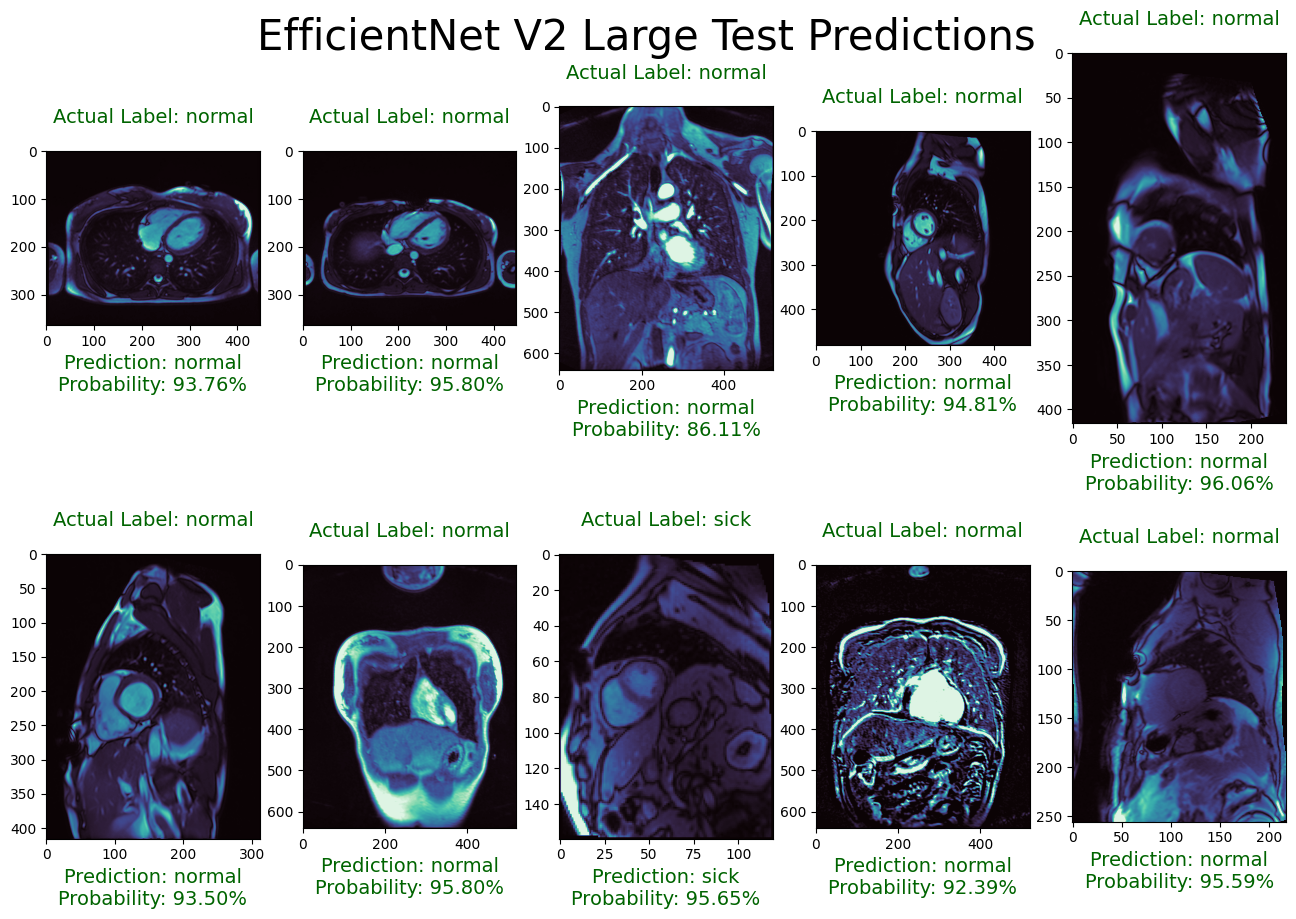

In [181]:
# View EfficientNet predictions
view_multiple_predictions(
    efficientnet_results,
    test_ds.classes,
    _load, 
    count=10, 
    color_map='mako', 
    title='EfficientNet V2 Large Test Predictions',
    fig_size=(16, 10)
)

**Inspect Incorrect Predictions**

In [150]:
# Query incorrect predictions
query_df = efficientnet_results[
    efficientnet_results['label_encoded'] != efficientnet_results['model_prediction']
].reset_index(drop=True)

# View incorrect predictions
query_df

image_path   label  label_encoded  \
0   /kaggle/working/dataset_split/test/sick/IM0001...    sick              1   
1   /kaggle/working/dataset_split/test/sick/IM0004...    sick              1   
2   /kaggle/working/dataset_split/test/sick/IM0007...    sick              1   
3   /kaggle/working/dataset_split/test/sick/IM0001...    sick              1   
4   /kaggle/working/dataset_split/test/sick/IM0004...    sick              1   
..                                                ...     ...            ...   
61  /kaggle/working/dataset_split/test/sick/IM0003...    sick              1   
62  /kaggle/working/dataset_split/test/sick/IM0004...    sick              1   
63  /kaggle/working/dataset_split/test/sick/IM0005...    sick              1   
64  /kaggle/working/dataset_split/test/sick/IM0001...    sick              1   
65  /kaggle/working/dataset_split/test/normal/img0...  normal              0   

    model_prediction  model_probability  
0                  0           0.936945  
1                  0           0.676342  
2                  0           0.611539  
3                  0           0.932580  
4                  0           0.880272  
..               ...                ...  
61                 0           0.916004  
62                 0           0.778532  
63                 0           0.932463  
64                 0           0.922926  
65                 1           0.615812  

[66 rows x 5 columns]

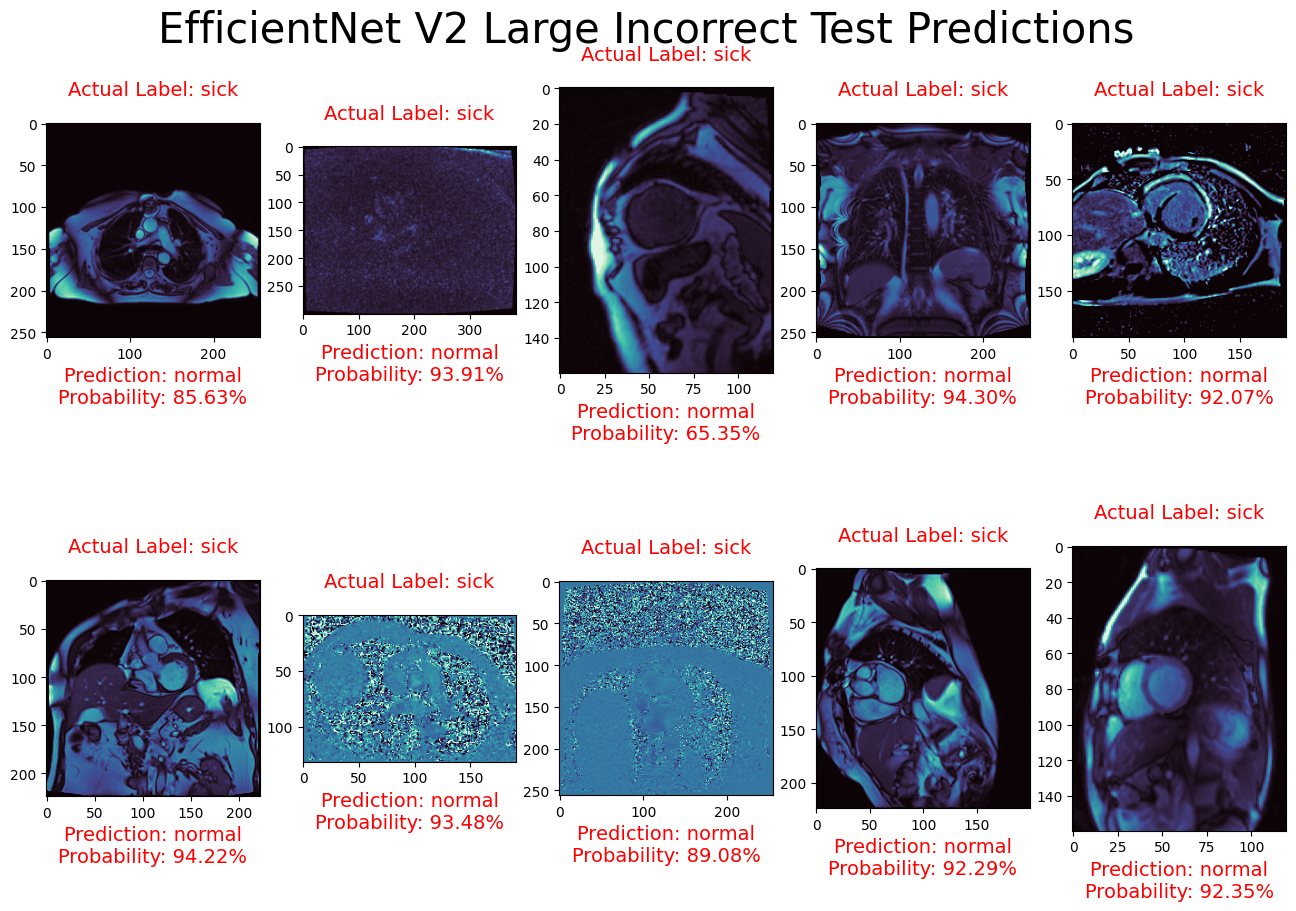

In [180]:
# View EfficientNet predictions
view_multiple_predictions(
    query_df,
    test_ds.classes,
    _load, 
    count=10, 
    color_map='mako', 
    title='EfficientNet V2 Large Incorrect Test Predictions',
    fig_size=(16,10)
)

## Conclusion

In conclusion, the innovation in this project is evident in its utilization of cutting-edge technology to transform CAD diagnosis. By integrating non-invasive methods like cardiac MRI imaging and harnessing the power of advanced deep learning techniques such as transfer learning with state-of-the-art architectures like EfficientNet V2, a paradigm shift in healthcare is achievable. This approach empowers healthcare professionals with enhanced diagnostic capabilities, enabling them to detect CAD earlier and administer more proactive management strategies. The adoption of such innovative methodologies not only improves patient outcomes but also mitigates the financial burden associated with late-stage CAD interventions. Moreover, the model's high accuracy underscores its reliability, fostering trust among both healthcare practitioners and patients. Ultimately, this project highlights the pivotal role of machine learning in advancing medical diagnostics, particularly in the domain of cardiovascular health, ushering in a new era of precision medicine.